# Entendendo o propósito

Esse estudo começou a partir de uma observação nos dados do Enem de 2022. Notamos que mais de 59% dos candidatos não forneceram informações sobre o tipo de escola do ensino médio que frequentaram. Diante desse cenário, foi decidido investigar a origem desses alunos.

A distinção das notas entres alunos de escola pública e privada existe, ao analisarmos a notas por faixa de renda, há uma regressão linear quase perfeita: maior a renda, maior a nota.  Claro que existe uma zona de conflito onde as notas se assemelham e os alunos de escola é muito maior do que o de privados e, dessa forma, ocorreram extremos que possuem notas de elite.

Mas para este trabalho, utilizou-se somente as notas das avaliações para criar um algoritmo de classificação baseadas nos rendimentos dos alunos. Se colocássemos a variável da renda seria muito mais prático, mas o objetivo é entender quanto a distinção das notas entre os tipos de escolas possibilita a utilização de algoritmo de classificação. É um caminho pouco usual para entender como a desigualdade influência a composição social no país. 

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# from joblib import dump, load,

from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier



from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier

In [3]:
def loading_file():
    # Read the CSV file with specific columns
    columns_to_read = ['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_ESCOLA']
    df2022 = pd.read_csv("MICRODADOS_ENEM_2022.csv", sep=";", encoding="latin-1", usecols=columns_to_read)
    df2022 = df2022.dropna()
    return df2022

In [4]:
df = loading_file()
df

,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
2,1,421.1,546.0,498.8,565.3,760.0
3,1,490.7,388.6,357.8,416.0,320.0
7,1,398.1,427.3,400.2,404.9,440.0
9,1,467.5,461.0,466.7,435.3,360.0
11,3,458.7,539.8,488.2,456.8,940.0
...,...,...,...,...,...,...
3476095,1,444.5,504.4,489.5,423.6,580.0
3476097,1,536.1,633.2,584.0,596.3,740.0
3476098,2,487.6,495.6,545.5,597.4,580.0
3476099,1,512.5,524.8,546.8,432.0,520.0


## Proporção no dados Brutos

Considerando o seguinte dicionário identificando os grupos:

- 1: Não definido
- 2: Escola Pública
- 3: Escola Privada

Pode-se ter a noção do tamanho de dados ausentes nesta categoria. As escolas privadas consistiram somente 8% do total de alunos e 32 % para escolas públicas. 



In [5]:
df['TP_ESCOLA'].value_counts(normalize=True).round(3).to_frame()

,proportion
TP_ESCOLA,
1,0.592
2,0.324
3,0.084


Nos box-plots, é possível observar que os dados relacionados aos candidatos que não especificaram a escola exibem distribuições com medianas superiores às das escolas públicas. Esse padrão sugere a presença de uma parcela de alunos provenientes de escolas particulares ou mesmo alunos de escolas públicas com desempenhos excepcionais.

C:\Users\filip\AppData\Local\Temp\ipykernel_10576\1335163070.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'TP_ESCOLA', y = column, data = df, palette = 'rocket')
C:\Users\filip\AppData\Local\Temp\ipykernel_10576\1335163070.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'TP_ESCOLA', y = column, data = df, palette = 'rocket')
C:\Users\filip\AppData\Local\Temp\ipykernel_10576\1335163070.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'TP_ESCOLA', y = column, data = df, palette = 'rocket')
C:\Users\filip\AppData\Local

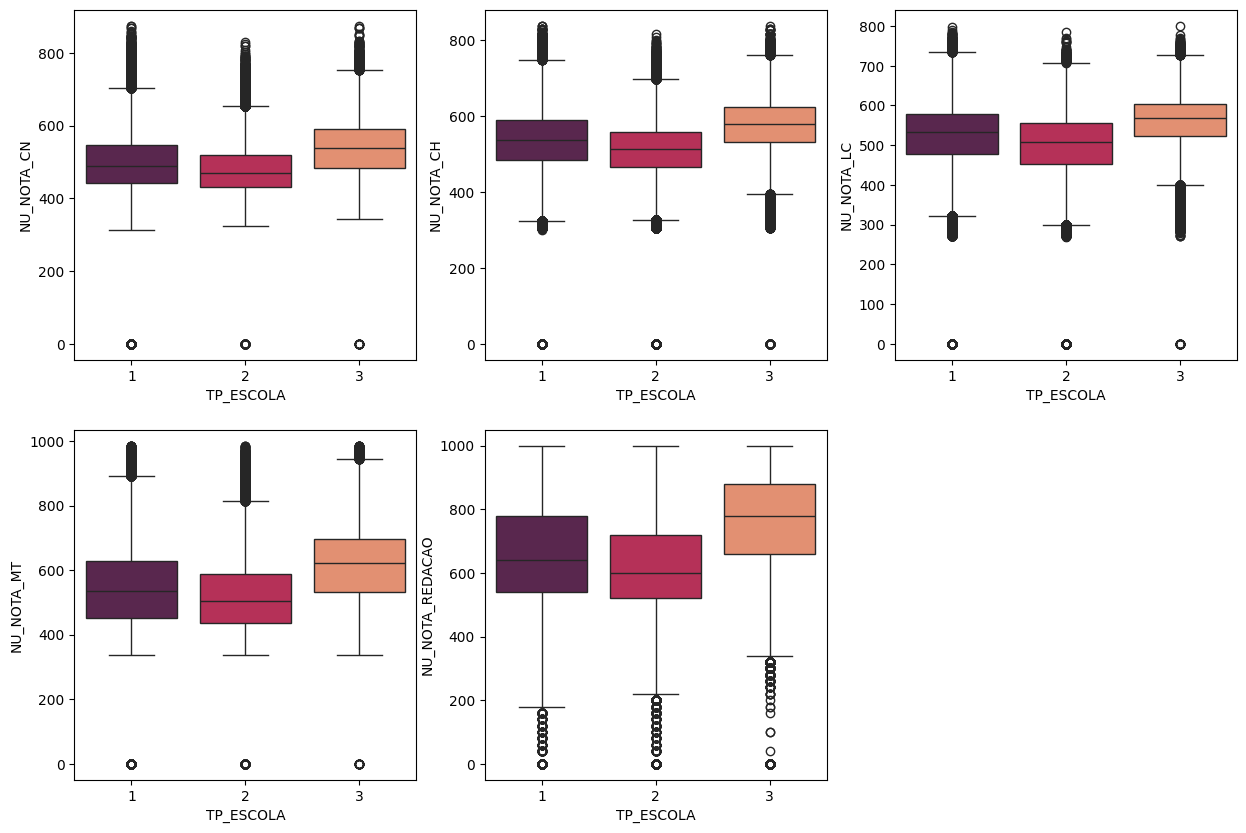

In [6]:
num_list = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
fig = plt.figure(figsize = (15,10))

for i in range(len(num_list)):
    column = num_list[i]
    sub = fig.add_subplot(2,3, i +1)
    sns.boxplot(x = 'TP_ESCOLA', y = column, data = df, palette = 'rocket')

## Proporção nos dados sem os indefinidos

Para a criação dos modelos, removemos do conjunto de dados original as notas associadas aos registros não definidos, resultando em uma alteração na distribuição proporcional dos alunos: de 79,4% para escolas públicas e 20,6% para escolas privadas.

In [7]:
df_N1 = df[df['TP_ESCOLA'] > 1]
df_N1 = df_N1[df_N1['NU_NOTA_CN'] >0]  
df_N1 = df_N1[df_N1['NU_NOTA_CH'] >0]  
df_N1 = df_N1[df_N1['NU_NOTA_LC'] >0]  
df_N1 = df_N1[df_N1['NU_NOTA_MT'] >0]  
df_N1 = df_N1[df_N1['NU_NOTA_REDACAO'] >0]  
df_N1['TP_ESCOLA'].value_counts(normalize=True).round(3).to_frame()

,proportion
TP_ESCOLA,
2,0.785
3,0.215


C:\Users\filip\AppData\Local\Temp\ipykernel_10576\3484418880.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'TP_ESCOLA', y = column, data = df_N1, palette = 'rocket')
C:\Users\filip\AppData\Local\Temp\ipykernel_10576\3484418880.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'TP_ESCOLA', y = column, data = df_N1, palette = 'rocket')
C:\Users\filip\AppData\Local\Temp\ipykernel_10576\3484418880.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'TP_ESCOLA', y = column, data = df_N1, palette = 'rocket')
C:\Users\filip\AppD

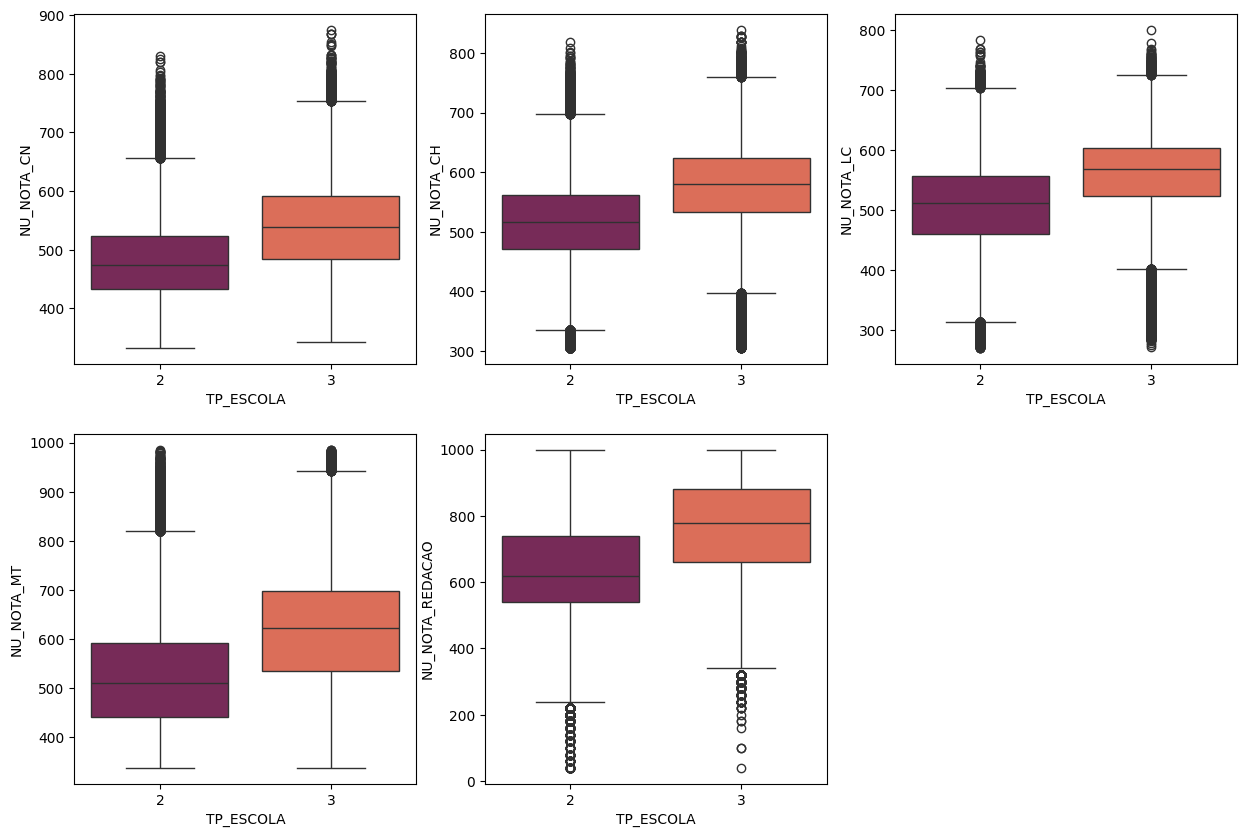

In [8]:
num_list = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
fig = plt.figure(figsize = (15,10))

for i in range(len(num_list)):
    column = num_list[i]
    sub = fig.add_subplot(2,3, i +1)
    sns.boxplot(x = 'TP_ESCOLA', y = column, data = df_N1, palette = 'rocket')

# Construção dos Modelos

Entre a opções de algoritmos classificatórios, utilizamos:

-	Regressão logística
-	Random Forest
-	Navy Bayes
-	Gradient Boosting
-	Adabosting
-   SVC
-   K Neighbors


Realizamos a divisão do conjunto de dados em conjuntos de teste e treino e realizamos os treinamentos mantendo os parâmetros default de cada modelo no sklearn. 


In [62]:
model_pipeline = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(),
    GaussianNB(),
    KNeighborsClassifier(),
    SGDClassifier()
]

models_classifier = ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'Logistic Regression', 'Naive Bayes', 'K Neighbors', 'SVC']
acc_list =[]
auc_list = []
cm_list = []

y = df_N1['TP_ESCOLA']
X = df_N1[['NU_NOTA_CH', 'NU_NOTA_CN' , 'NU_NOTA_MT' , 'NU_NOTA_LC', 'NU_NOTA_REDACAO']]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=16)

In [10]:
for model, name in zip(model_pipeline, models_classifier):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc_list.append(round(metrics.accuracy_score(y_test, y_pred), 3))
    
    lb = LabelBinarizer()
    y_test_binary = lb.fit_transform(y_test)
    y_pred_binary = lb.transform(y_pred)
    
    fpr, tpr, _ = metrics.roc_curve(y_test_binary, y_pred_binary)
    auc_list.append(round(metrics.auc(fpr, tpr), 3))
    
    cm_list.append(metrics.confusion_matrix(y_test, y_pred))
    
    # Save model
    with open(f'{name}_classifier.pkl', "wb") as pickle_out:
        pickle.dump(model, pickle_out)

# Avaliação dos modelos


Para avaliar os modelos construídos, utilizamos a matriz de confusão, a acurácia e a AUC como métricas. Observamos uma acurácia em torno de 80% em todos os modelos, enquanto a AUC fica próxima de 60%. No entanto, a análise mais relevadora é da matriz de confusão, mostrando a dificuldade dos modelos em identificar corretamente os alunos de escolas privadas. Os erros nessa categoria chegam a 70%, enquanto para escolas públicas ficam em 5%.

O modelo Naive Bayes apresenta uma acurácia de 56,69% para escolas privadas e AUC de 70%, superando os demais. No entanto, esse modelo também aumenta os erros na identificação de alunos de escolas públicas para 17%. Apesar disso, optamos por esse modelo, pois oferece uma previsão razoável, embora não seja perfeito. Ainda há espaço para testes e aprimoramentos futuros, já que as possibilidades de construção são quase infinitas.


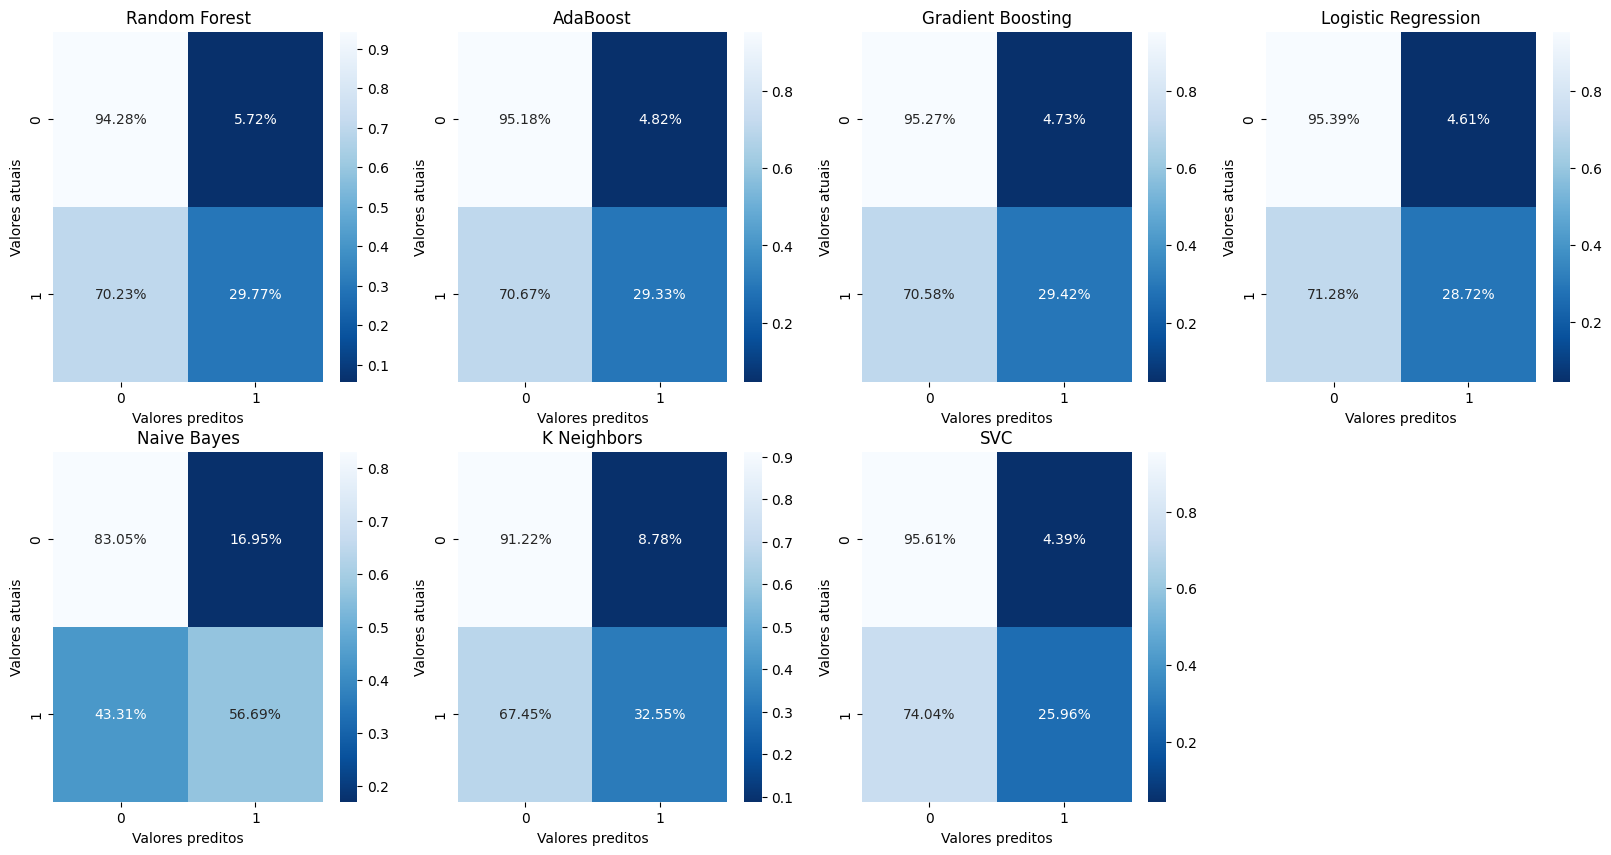

In [28]:
fig = plt.figure(figsize = (20,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    name = models_classifier[i]

    row_sums = cm.sum(axis=1)
    cm_percentages = cm / row_sums[:, np.newaxis]


    sub = fig.add_subplot(2,4, i + 1).set_title(name)
    cm_plot = sns.heatmap(cm_percentages, annot = True, fmt=".2%", cmap = 'Blues_r')
    cm_plot.set_xlabel('Valores preditos')
    cm_plot.set_ylabel('Valores atuais')

In [16]:
result_df = pd.DataFrame({'Model':models_classifier, 'Acurácia':acc_list, 'AUC':auc_list} )
result_df

,Model,Acurácia,AUC
0,Random Forest,0.804,0.620
1,AdaBoost,0.810,0.623
2,Gradient Boosting,0.811,0.623
3,Logistic Regression,0.811,0.621
4,Naive Bayes,0.774,0.699
5,K Neighbors,0.786,0.619
6,SVC,0.806,0.608


Utilizando o modelo escolhido, conseguimos classificar os estudantes que não identificaram a escola de ensino médio. Com isso, constatamos que 72,16% desses estudantes provêm de escolas públicas e 27,83% de escolas privadas. Considerando o erro apresentado, podemos afirmar que a proporção está na faixa de 70/30 em relação à escolha pública e privada.

In [30]:
def predict_values(model_file_path):
    
    X_S1 = df_S1[['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']]

    with open(model_file_path, "rb") as pickle_in:
        model = pickle.load(pickle_in)

    value_counts = model.predict(X_S1)
    return value_counts

df_S1 = df[df['TP_ESCOLA'] == 1]
df_S1['Previsto Modelo'] = predict_values("Naive Bayes_classifier.pkl")
df_S1['Previsto Modelo'].value_counts(normalize=True)


C:\Users\filip\AppData\Local\Temp\ipykernel_10576\2301197206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S1['Previsto Modelo'] = predict_values("Naive Bayes_classifier.pkl")


Previsto Modelo
2    0.72168
3    0.27832
Name: proportion, dtype: float64

# Metodos Essemble

Na busca por um modelo mais eficiente, exploramos dois modelos Ensemble, que essencialmente combinam vários modelos em uma única solução. Utilizamos o Weighted Average e o Stacking. O Weighted Average é uma média ponderada das previsões dos modelos, enquanto o Stacking divide o conjunto de dados entre algoritmos para realizar as predições.

Os modelos não apresentaram resultados satifatórios.

### Método Essemble: Weighted Average

In [ ]:
# Load the pickled models
with open("Naive Bayes_classifier.pkl", "rb") as file:
    classifier_NB = pickle.load(file)

with open("K Neighbors_classifier.pkl", "rb") as file:
    classifier_NK = pickle.load(file)

predictions_NB = classifier_NB.predict(X_test)
predictions_NK = classifier_NK.predict(X_test)

In [76]:
# Assign weights to the predictions of each model
weight_NB = 0.8  # Weight for Naive Bayes
weight_NK = 0.2# Weight for K Neighbors

y_pred = (weight_NB * predictions_NB) + (weight_NK * predictions_NK)
y_pred = np.round(y_pred).astype(int)

Text(45.722222222222214, 0.5, 'Valores atuais')

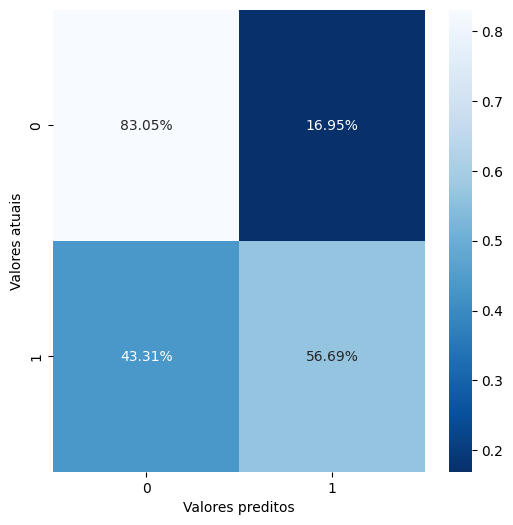

In [77]:

cm_emseble1 = metrics.confusion_matrix(y_test, y_pred)
row_sums = cm_emseble1.sum(axis=1)
cm_percentages = cm_emseble1 / row_sums[:, np.newaxis]

fig = plt.figure(figsize = (6,6))
cm_plot = sns.heatmap(cm_percentages, annot = True, fmt=".2%", cmap = 'Blues_r')
cm_plot.set_xlabel('Valores preditos')
cm_plot.set_ylabel('Valores atuais')


# Método Ensemble: Stacking

In [80]:
base_models = [
    ('LogisticRegression', LogisticRegression()),
    ('GaussianNB', GaussianNB()),
    ('KNeighbors', KNeighborsClassifier())
]

meta_classifier = LogisticRegression() 

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_classifier)

In [81]:
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate the stacking model
accuracy_stacking = np.mean(y_pred_stacking == y_test)
print(f"Accuracy of Stacking Classifier: {accuracy_stacking:.3f}")

Accuracy of Stacking Classifier: 0.810


Text(45.722222222222214, 0.5, 'Valores atuais')

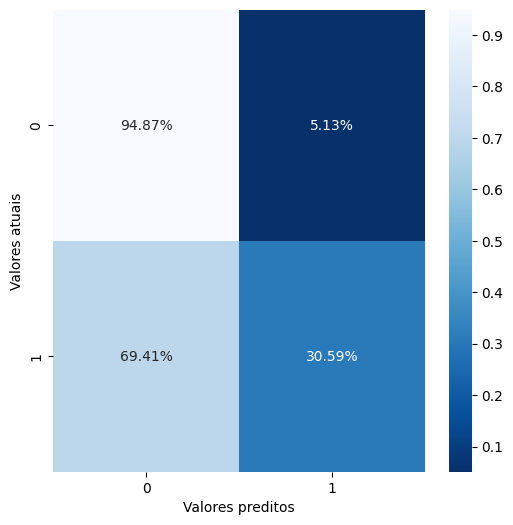

In [82]:

cm_emseble2 = metrics.confusion_matrix(y_test, y_pred_stacking)
row_sums = cm_emseble1.sum(axis=1)
cm_percentages = cm_emseble2/ row_sums[:, np.newaxis]

fig = plt.figure(figsize = (6,6))
cm_plot = sns.heatmap(cm_percentages, annot = True, fmt=".2%", cmap = 'Blues_r')
cm_plot.set_xlabel('Valores preditos')
cm_plot.set_ylabel('Valores atuais')

# Conclusão

Os resultados obtidos indicam a viabilidade de prever o tipo de escola com base nas notas, conforme previsto. No entanto, há desafios na identificação das escolas privadas. Recomenda-se a exploração de modelos mais complexos que possam oferecer uma eficácia aprimorada. Atos para o próximo capítulo.